In [60]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import Compose, ToTensor, Normalize

from utils import DatasetStatistics, plot_predictions
from model import UNet
from dataset import SentinelNO2Dataset
from transforms import TargetNormalize

torch.manual_seed(42)

In [61]:
datastats = DatasetStatistics(
    "../data/samples/samples_S2S5P_2018_2020_eea.csv", "../data/sentinel-2-eea"
)

In [62]:
transform = Compose([ToTensor(), Normalize(datastats.band_means, datastats.band_std)])
target_transform = TargetNormalize(datastats.no2_mean, datastats.no2_std)

In [63]:
dataset = SentinelNO2Dataset(
    "../data/samples/samples_S2S5P_2018_2020_eea.csv",
    "../data/sentinel-2-eea",
    n_patches=4,
    patch_size=(100, 100),
    pre_load=True,
    transform=transform,
    target_transform=target_transform,
)

In [64]:
len(dataset)

12348

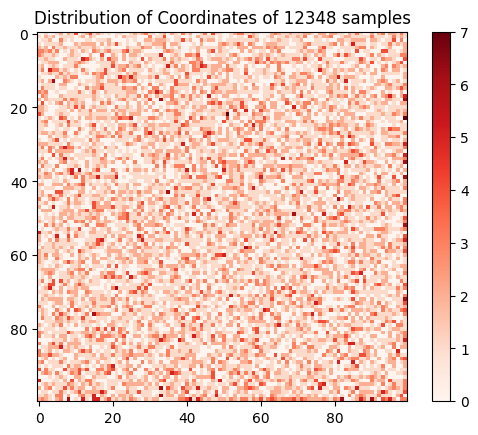

In [65]:
dataset.plot_coords_distribution()

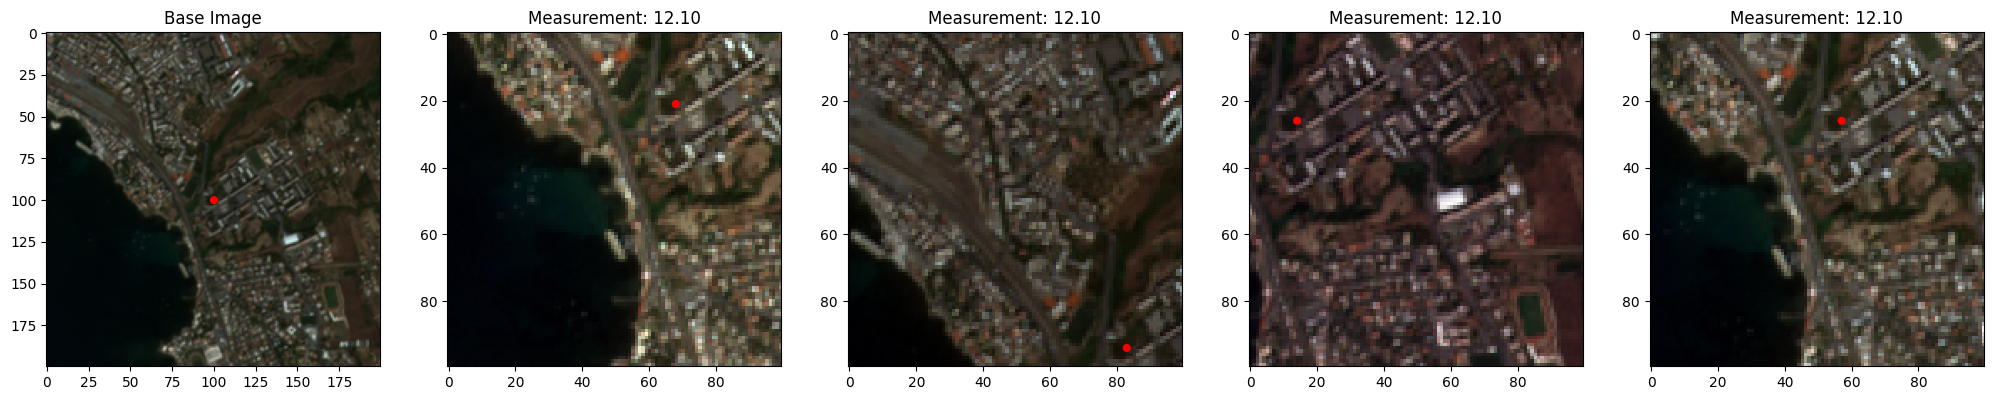

In [66]:
dataset.plot_patches(5)

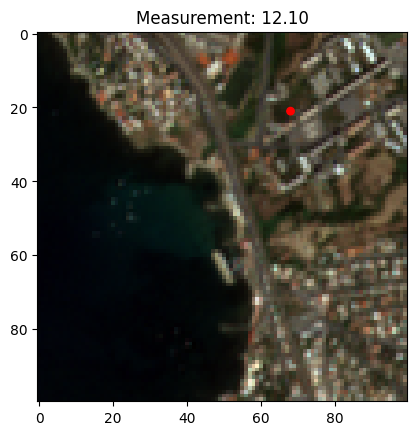

In [67]:
dataset.plot(5)

In [68]:
net = UNet()

In [69]:
training_data, test_data = random_split(dataset, [0.7, 0.3])

In [70]:
batch_size = 64
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [71]:
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [59]:
for epoch in range(1):
    running_loss = 0.0

    for i, item in enumerate(train_dataloader, 0):
        # Get the relevant data
        data, no2, coords = item

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(data)

        # Get the target values by coordinates
        target_values = torch.diag(outputs[:, 0, coords[0], coords[1]])

        loss = criterion(target_values, no2)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 50 == 49:  # print every 50 mini-batches
            
            print(f"[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 50:.3f}")
            running_loss = 0.0

print("Finished Training")

[1,    50] loss: 0.666
[1,   100] loss: 0.669
Finished Training


In [72]:
dataiter = iter(test_dataloader)
data, no2, coords = next(dataiter)

In [73]:
outputs = net(data)


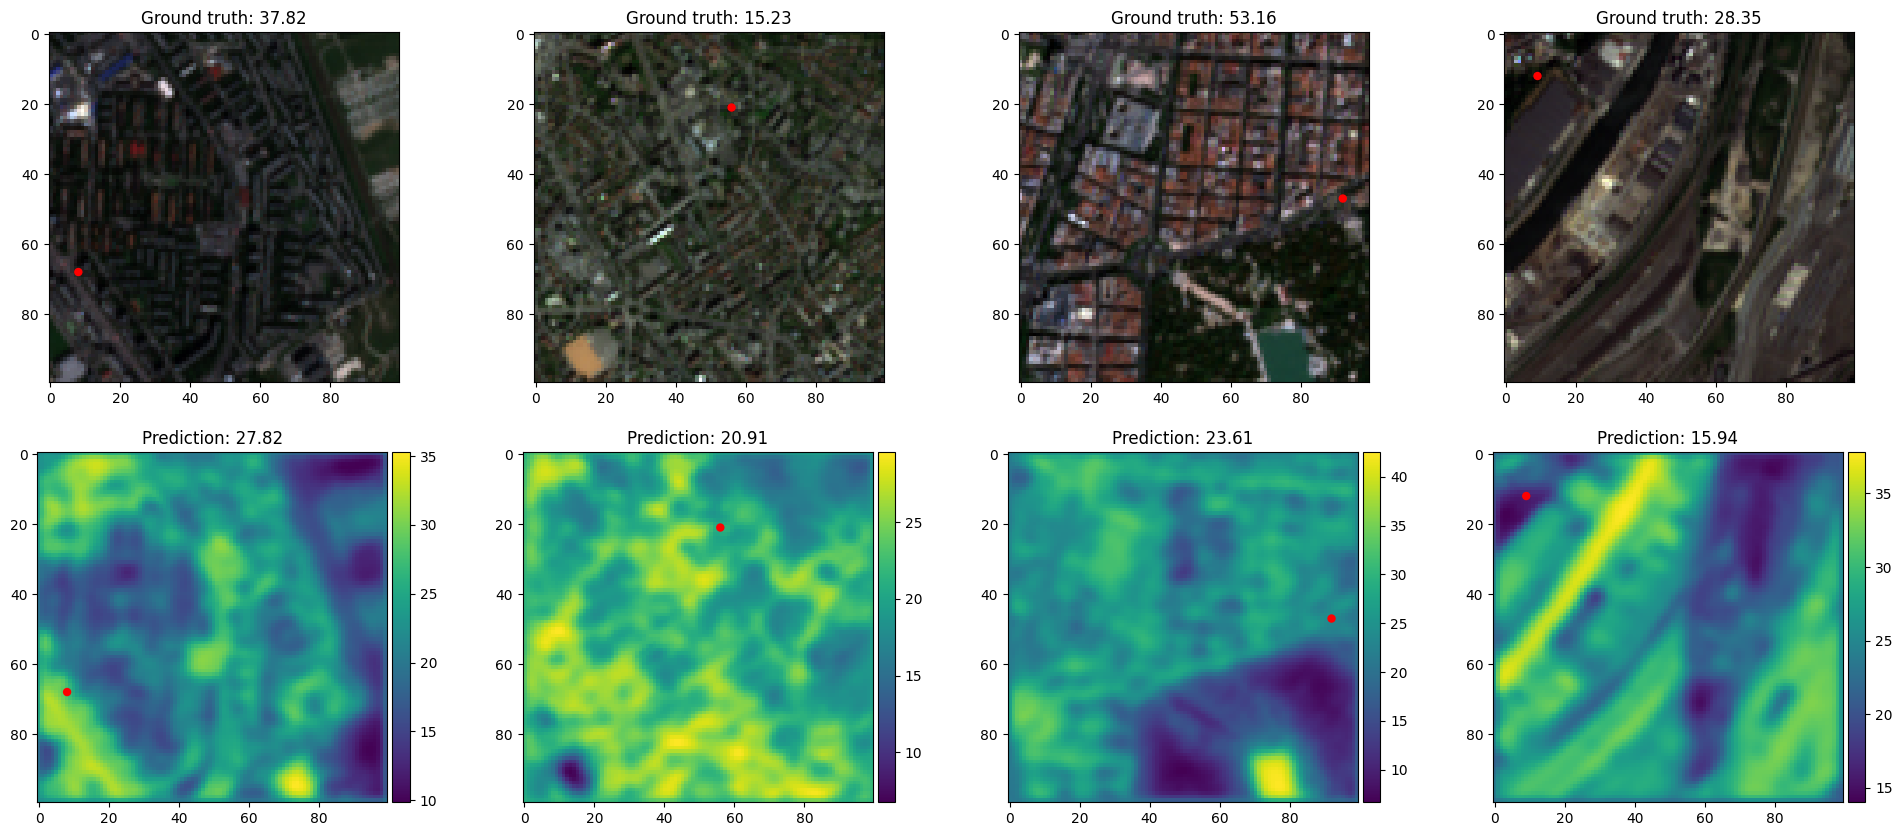

In [74]:
plot_predictions(data, no2, coords, outputs, target_transform)